# Convolutional Neural Networks: Application

## 1.0 - TensorFlow model

In [3]:
# Import essential libraries for numerical operations, visualization, and machine learning
import math             # Math operations (will be used later in the code)
import numpy as np      # Numerical operations with arrays
import h5py             # HDF5 file handling (will be used later)
import matplotlib.pyplot as plt  # Visualization
import scipy            # Scientific and mathematical functions
from PIL import Image   # Image processing (will be used later)
from scipy import ndimage  # Multidimensional image processing
import tensorflow as tf  # TensorFlow for machine learning models (eager execution enabled by default)
from cnn_utils import *  # Custom utilities for CNN

# Configure matplotlib for inline display in Jupyter notebooks
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(1)


2024-11-23 22:54:07.778972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 22:54:07.810170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 22:54:07.819709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 22:54:07.842548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 22:54:09.260883: W tensorflow/compiler/tf2

In [4]:
# Load the dataset (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


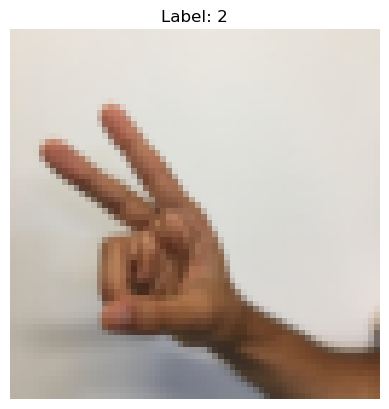

In [5]:
# Display an example image from the training set along with its label
index = 6  # Index of the image to display
plt.imshow(X_train_orig[index])  # Show the image at the specified index
plt.title(f"Label: {np.squeeze(Y_train_orig[:, index])}")  # Display the label as the title
plt.axis('off')  # Hide axis for a cleaner display
plt.show()  # Display the image


In [6]:
# Normalize the input image data by scaling pixel values to the range [0, 1]
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0

# Convert labels to one-hot encoding for a 6-class classification task
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

# Display dataset information
print(f"Number of training examples: {X_train.shape[0]}")
print(f"Number of test examples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

# Initialize a dictionary to store convolutional layers, if needed later
conv_layers = {}


Number of training examples: 1080
Number of test examples: 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 1.2 - Initialize parameters

In [8]:
def initialize_parameters():
    """
    Initializes weight parameters for a convolutional neural network.
    
    Returns:
    parameters -- a dictionary containing initialized weight tensors W1 and W2, 
                  representing the convolutional filters (kernels) for each layer.
    """
    
    # Set random seed for reproducibility
    tf.random.set_seed(1)
    
    # Define Xavier initializer for weight (filter/kernel) initialization
    initializer = tf.keras.initializers.GlorotUniform(seed=0)

    # Initialize weights for the first convolutional layer (filter/kernel)
    W1 = tf.Variable(initializer(shape=(4, 4, 3, 8)), name="W1")

    # Initialize weights for the second convolutional layer (filter/kernel)
    W2 = tf.Variable(initializer(shape=(2, 2, 8, 16)), name="W2")

    parameters = {"W1": W1, "W2": W2}
    
    return parameters


In [9]:
import tensorflow as tf

# Reinitialize parameters using TensorFlow 2.x eager execution
parameters = initialize_parameters()  # Call the previously defined initialize_parameters function

# Display specific entries and shapes for the weights/kernels W1 and W2
print("W1[1,1,1] = \n", parameters["W1"][1, 1, 1].numpy())
print(f"W1 shape: {parameters['W1'].shape}\n")

print("W2[1,1,1] = \n", parameters["W2"][1, 1, 1].numpy())
print(f"W2 shape: {parameters['W2'].shape}")


W1[1,1,1] = 
 [-0.05346771  0.18349849 -0.01215445  0.00138046  0.0012947  -0.02904211
 -0.11260509 -0.143055  ]
W1 shape: (4, 4, 3, 8)

W2[1,1,1] = 
 [-0.1713624   0.09527719 -0.0744766  -0.02245569  0.24450928 -0.06879854
  0.21546292 -0.08803296 -0.16513646 -0.19527972 -0.22957063  0.15745944
  0.13090086 -0.12304181 -0.05287278  0.03434092]
W2 shape: (2, 2, 8, 16)


## 1.3 - Forward propagation

In [11]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for a convolutional neural network:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input tensor of shape (batch_size, height, width, channels)
    parameters -- dictionary containing the model's parameters "W1" and "W2"

    Returns:
    Z3 -- the output logits of the final fully connected layer
    """
    
    # Retrieve weights/kernels from parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # First Convolutional Layer
    Z1 = tf.nn.conv2d(X, W1, strides=1, padding='SAME')  # Convolution with stride 1
    A1 = tf.nn.relu(Z1)  # ReLU activation
    P1 = tf.nn.max_pool(A1, ksize=8, strides=8, padding='SAME')  # Max Pooling with 8x8 window and stride 8

    # Second Convolutional Layer
    Z2 = tf.nn.conv2d(P1, W2, strides=1, padding='SAME')  # Convolution with stride 1
    A2 = tf.nn.relu(Z2)  # ReLU activation
    P2 = tf.nn.max_pool(A2, ksize=4, strides=4, padding='SAME')  # Max Pooling with 4x4 window and stride 4

    # Flatten the output from the final pooling layer
    F = tf.reshape(P2, [P2.shape[0], -1])  # Flatten the output for the fully connected layer

    # Fully connected layer (output layer with 6 logits, no activation)
    num_outputs = 6
    Z3 = tf.keras.layers.Dense(units=num_outputs, activation=None)(F)

    return Z3


In [12]:
# Set random seed for reproducibility
np.random.seed(1)

# Generate random input data for testing
X_input = np.random.randn(2, 64, 64, 3).astype(np.float32)  # Input tensor with shape (2, 64, 64, 3)
Y_input = np.random.randn(2, 6).astype(np.float32)          # Target tensor with shape (2, 6)

# Initialize model parameters
parameters = initialize_parameters()  # Initialize weights / kernels

# Perform forward propagation
Z3 = forward_propagation(X_input, parameters)

# Display the output of the forward pass
print("Z3 = \n", Z3.numpy())


Z3 = 
 [[ 2.1385474   1.1307205   1.8627117   0.75046617  1.4149714  -0.8105242 ]
 [ 2.264759    0.98640007  2.1668441   0.75986004  1.30066    -0.7276745 ]]


## 1.4 - Compute cost

In [14]:
# GRADED FUNCTION: compute_cost

def compute_cost(Z3, Y):
    """
    Computes the cost using softmax cross entropy loss.
    
    Arguments:
    Z3 -- output of the forward propagation (last layer's raw output), shape: (number of examples, 6)
    Y -- true labels, one-hot encoded, same shape as Z3
    
    Returns:
    cost -- Tensor representing the mean cost value
    """
    
    # Compute the softmax cross entropy loss and take the mean over all examples
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost


In [15]:
# Example training data
X_train = np.random.randn(4, 64, 64, 3)  # Example input data
Y_train = np.random.randn(4, 6)  # Example labels

# Initialize parameters and perform forward propagation
parameters = initialize_parameters()
Z3 = forward_propagation(X_train, parameters)

# Compute cost
cost = compute_cost(Z3, Y_train)

print(f"Cost: {cost.numpy()}")


Cost: -0.7548933029174805


## 1.5 - Model

In [17]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epochs=100, batch_size=64, print_cost=True):
    """
    Implements a three-layer ConvNet in TensorFlow 2.x with the architecture:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE.
    
    Arguments:
    X_train -- training set, of shape (m, 64, 64, 3)
    Y_train -- training labels, of shape (m, n_y = 6)
    X_test -- test set, of shape (m_test, 64, 64, 3)
    Y_test -- test labels, of shape (m_test, n_y = 6)
    learning_rate -- learning rate of the optimizer
    num_epochs -- number of epochs
    batch_size -- size of each minibatch
    print_cost -- if True, prints the cost every 5 epochs
    
    Returns:
    train_accuracy -- accuracy on the training set
    test_accuracy -- accuracy on the test set
    parameters -- model weights after training
    """

    # Define the model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, (4, 4), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((8, 8), strides=8, padding='same'),
        tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((4, 4), strides=4, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=2)

    # Plot the cost
    if print_cost:
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(f"Learning rate = {learning_rate}")
        plt.show()

    # Evaluate accuracy on training and test sets
    train_accuracy = model.evaluate(X_train, Y_train, verbose=0)[1]
    test_accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    # Retrieve and return model parameters
    parameters = model.get_weights()
    
    return train_accuracy, test_accuracy, parameters


Epoch 1/100


/home/muhammad-saqib/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 - 2s - 2s/step - accuracy: 0.5000 - loss: -1.8224e+00 - val_accuracy: 0.1667 - val_loss: 1.8515
Epoch 2/100
1/1 - 0s - 397ms/step - accuracy: 0.5000 - loss: -4.7049e+00 - val_accuracy: 0.1667 - val_loss: 1.9010
Epoch 3/100
1/1 - 0s - 120ms/step - accuracy: 0.5000 - loss: -7.8211e+00 - val_accuracy: 0.1667 - val_loss: 1.9970
Epoch 4/100
1/1 - 0s - 114ms/step - accuracy: 0.5000 - loss: -1.1024e+01 - val_accuracy: 0.1667 - val_loss: 2.1530
Epoch 5/100
1/1 - 0s - 118ms/step - accuracy: 0.5000 - loss: -1.4643e+01 - val_accuracy: 0.1667 - val_loss: 2.3914
Epoch 6/100
1/1 - 0s - 115ms/step - accuracy: 0.5000 - loss: -1.9135e+01 - val_accuracy: 0.1667 - val_loss: 2.7157
Epoch 7/100
1/1 - 0s - 112ms/step - accuracy: 0.5000 - loss: -2.4338e+01 - val_accuracy: 0.1667 - val_loss: 3.1288
Epoch 8/100
1/1 - 0s - 109ms/step - accuracy: 0.5000 - loss: -3.0216e+01 - val_accuracy: 0.1667 - val_loss: 3.6331
Epoch 9/100
1/1 - 0s - 108ms/step - accuracy: 0.5000 - loss: -3.7147e+01 - val_accuracy: 0.1667

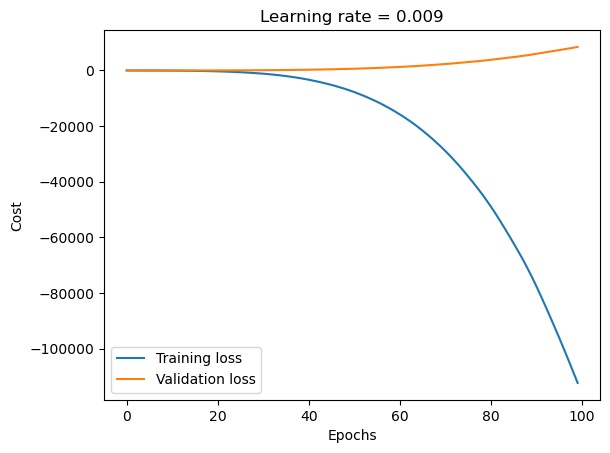

Train Accuracy: 0.0
Test Accuracy: 0.1666666716337204


In [18]:
# Only retrieve the parameters, ignore the other returned values
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
